# Model building

In [1]:
import pickle
from pathlib import Path

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import cross_val_score, HalvingGridSearchCV, train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV

%cd ..

import src.configuration as config

/workspaces/Dansah2_Aviation_Final_Project


## 1. Load data

In [2]:
train_df=pd.read_csv(config.TRAINING_DATAFILE)
test_df=pd.read_csv(config.TESTING_DATAFILE)

In [ ]:
# visual check of the training data
train_df.head(5).T

,0,1,2,3,4
incident,0.000000,0.000000,0.000000,0.000000,0.000000
time_sin,-0.958820,0.996566,-0.884988,0.370557,-0.760406
time_cos,0.284015,-0.082808,-0.465615,-0.928810,0.649448
route_encoded,62.000000,240.000000,154.000000,39.000000,561.000000


In [ ]:
# visual check of the testing data
test_df.head(5).T

,0,1,2,3,4
incident,1.000000,0.000000,0.000000,0.000000,0.000000
time_sin,0.766044,-0.998630,0.533615,0.258819,0.074108
time_cos,0.642788,0.052336,-0.845728,-0.965926,-0.997250
route_encoded,1.000000,93.000000,575.000000,249.000000,151.000000


## 2. Cross-validation: model

In [3]:
# create a function that performs cross validation of the model
def cross_val_boosting_model(training_data: pd.DataFrame, testing_data: pd.DataFrame, target_variable: str, model):
    X_train = training_data.drop(columns=target_variable)
    y_train = training_data[target_variable]
    X_test = testing_data.drop(columns=target_variable)
    y_test = testing_data[target_variable]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(scores)
    return X_train, y_train, y_test, y_pred

hist_boost_model = HistGradientBoostingClassifier(random_state=42)
X_train, y_train, y_test, y_pred = cross_val_boosting_model(train_df, test_df, 'incident', hist_boost_model)

[0.99635466 0.99654054 0.9959209  0.99622037 0.99625136]


## 3. Test-set performance: confusion matrix

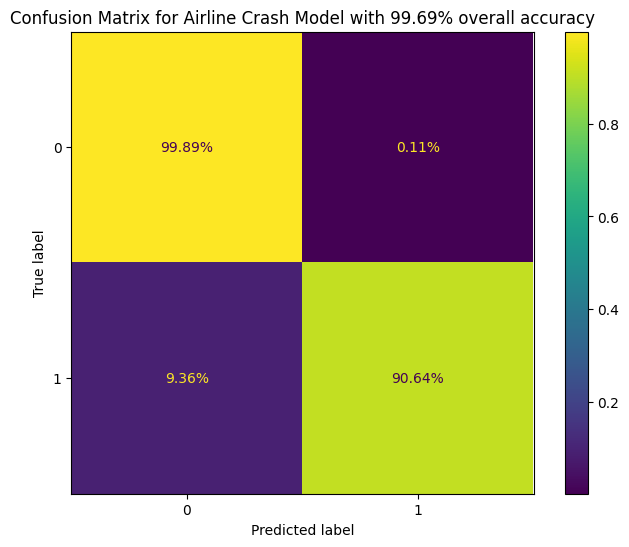

In [ ]:
# plot a confusion matrix to evaluate the model's performance on unseen data
def confusion_plot(y_test, y_pred, model):
    acc = accuracy_score(y_test, y_pred)*100
    conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    display = ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_)
    ax.set(title=f'Confusion Matrix for Airline Crash Model with {acc:.2f}% overall accuracy')
    display.plot(ax=ax, values_format='.2%');

confusion_plot(y_test, y_pred, hist_boost_model)

## 4. Model optimization

### Probability Calibration

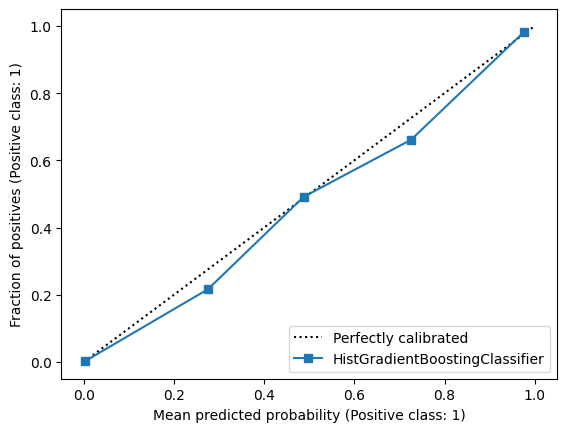

In [ ]:
# create a functions that checks the calibration of the probabilities of the model
def calibration_plot(model, testing_data: pd.DataFrame, target_variable: str):
    X_test = testing_data.drop(columns=target_variable)
    y_test = testing_data[target_variable]
    disp = CalibrationDisplay.from_estimator(model, X_test, y_test)
    plt.show()

calibration_plot(hist_boost_model, test_df, 'incident')

In [ ]:
# calibrate the probabilities of the model
def calibrate_probability(model, training_data: pd.DataFrame, target_variable: str):
    X_train = training_data.drop(columns=target_variable)
    y_train = training_data[target_variable]
    calibrated_hist_boost_model = CalibratedClassifierCV(model, cv=5)
    calibrated_hist_boost_model.fit(X_train, y_train)
    return calibrated_hist_boost_model

calibrated_hist_boost_model = calibrate_probability(hist_boost_model, train_df, 'incident')

In [ ]:
# create a model that obtains the predictions of the calibrated model
def predict_calibrated_probabilities(testing_data: pd.DataFrame, target_variable: str):
    X_test = testing_data.drop(columns=target_variable)
    y_true = testing_data[target_variable]
    calibrated_probability = calibrated_hist_boost_model.predict_proba(X_test)
    return calibrated_probability

calibrated_probability = predict_calibrated_probabilities(test_df, 'incident')

In [ ]:
# do a visual check of the positive class probabilities
positive_class_probability = calibrated_probability[:, 1]
positive_class_probability = positive_class_probability * 100
positive_class_probability

array([9.94809667e+01, 4.75825583e-02, 2.25995527e-02, ...,
       3.03073187e+00, 2.13259419e+00, 2.19343660e-02])

In [ ]:
# check how many unique probabilities there are
np.unique(positive_class_probability).size

14990

In [ ]:
# visual inspection of unique probabilities
np.unique(positive_class_probability)

array([9.53926736e-03, 1.40858182e-02, 1.50467994e-02, ...,
       9.94896328e+01, 9.94907235e+01, 9.94940660e+01])

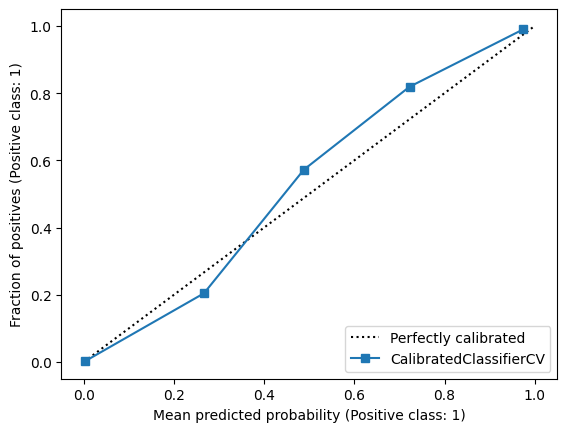

In [ ]:
# plot the calibrated model
calibration_plot(calibrated_hist_boost_model, test_df, 'incident')

In [ ]:
# obtain the predictions of the calibrated model
def get_predictions(training_data: pd.DataFrame, testing_data: pd.DataFrame, target_variable: str, model):
    X_train = training_data.drop(columns=target_variable)
    y_train = training_data[target_variable]
    X_test = testing_data.drop(columns=target_variable)
    y_test = testing_data[target_variable]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(y_pred) 
    return y_pred, y_test

y_pred, y_test = get_predictions(train_df, test_df, 'incident', calibrated_hist_boost_model)

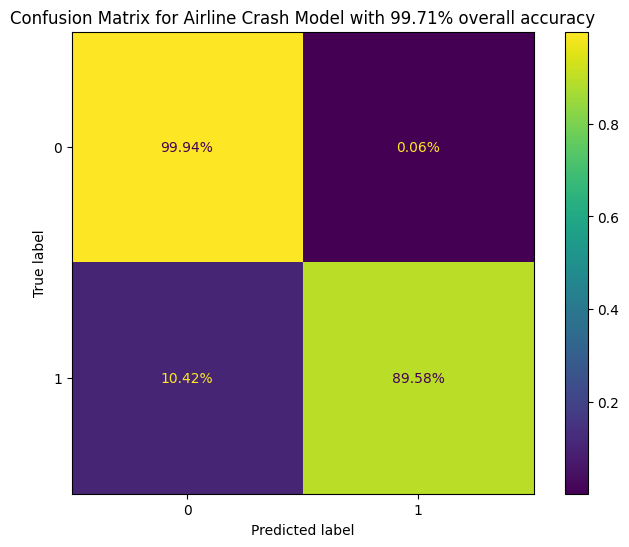

In [ ]:
# plot the confusion matrix of the calibrated model
confusion_plot(y_test, y_pred, calibrated_hist_boost_model)

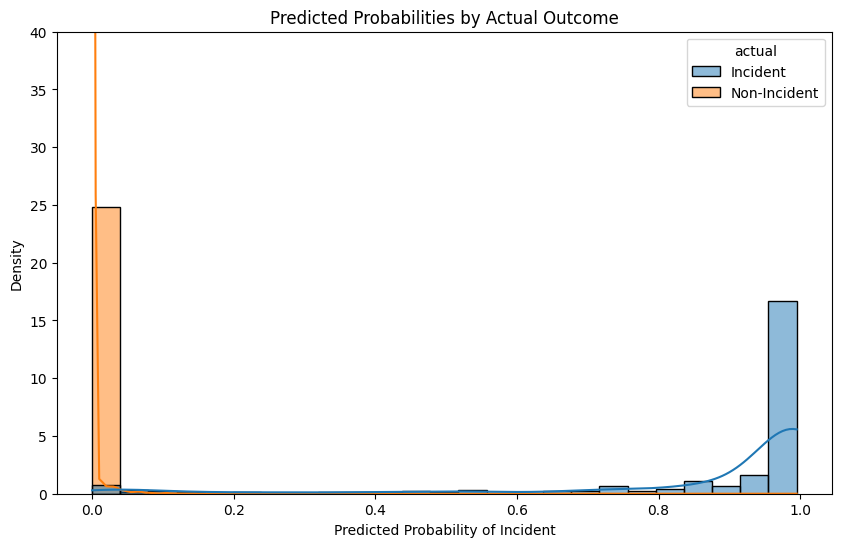

In [ ]:
# plot the probabilities of the calibrated model
def probabilities_plot(model, testing_data):
    y_true = testing_data['incident']
    X_test = testing_data.drop(columns=['incident'])
    prob_incident = model.predict_proba(X_test)[:, 1]
    plot_df = pd.DataFrame({
        'probability': prob_incident,
        'actual': y_true.map({0: 'Non-Incident', 1: 'Incident'})
    })

    # Plot the distributions
    plt.figure(figsize=(10, 6))
    sns.histplot(data=plot_df, x='probability', hue='actual', bins=25, kde=True, stat='density', common_norm=False)
    plt.title('Predicted Probabilities by Actual Outcome')
    plt.xlabel('Predicted Probability of Incident')
    plt.ylabel('Density')
    plt.ylim(top=40)
    plt.show()

probabilities_plot(calibrated_hist_boost_model, test_df)

### Hyperparameter Tuning

In [ ]:
# optimize the model via hyperparameter tuning
def get_best_params(model, optimizer):
    hyper_params = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
        'max_iter': [100, 200, 500, 1000],
        'max_leaf_nodes': [15, 31, 63, 127],
        'l2_regularization': [0.0, 0.1, 1.0, 10.0],
    }

    grid = optimizer(model, hyper_params, scoring='balanced_accuracy', cv=5, n_jobs=-1)
    return grid

grid = get_best_params(hist_boost_model, HalvingGridSearchCV)

In [ ]:
# obtain the best hyperparameters
run_grid = True

if run_grid:
    def warn(*args, **kwargs):
        pass
    import warnings
    warnings.warn = warn

    grid.fit(X_train, y_train)

    print(f"Best hyperparameters: {grid.best_params_}")

Best hyperparameters: {'l2_regularization': 10.0, 'learning_rate': 0.01, 'max_iter': 1000, 'max_leaf_nodes': 31}


In [4]:
# create an optimized model based on the best hyperparameters
optimized_hist_boost_model = HistGradientBoostingClassifier(l2_regularization= 10.0, learning_rate= 0.01, max_iter= 1000, max_leaf_nodes= 31, random_state=42)

X_train, y_train, y_test, y_pred = cross_val_boosting_model(train_df, test_df, 'incident', optimized_hist_boost_model)

[0.99692263 0.99691231 0.99645789 0.99658181 0.99663345]


In [7]:
# obtain the predictions from the optimized model
y_pred, y_test = get_predictions(train_df, test_df, 'incident', optimized_hist_boost_model)

[1 0 0 ... 0 0 0]


## 5. Feature Importances

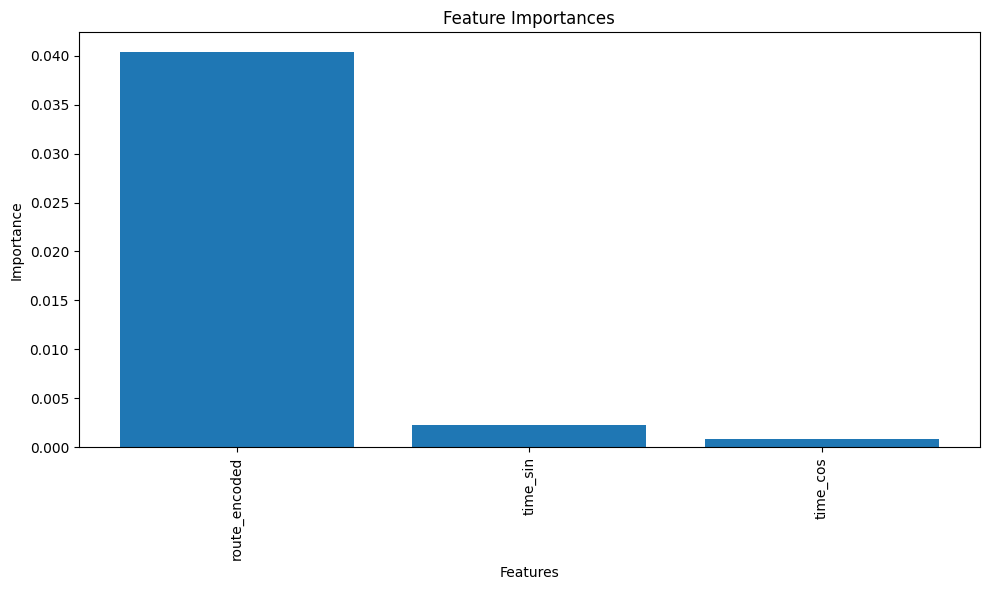

In [8]:
from sklearn.inspection import permutation_importance

def feature_importance_plot(model, training_data, sample_size=5000):
    # Compute permutation importances
    X = training_data.drop('incident', axis=1)
    y = training_data['incident']
    X_sample = X.sample(sample_size, random_state=42)
    y_sample = y.loc[X_sample.index]
    result = permutation_importance(model, X_sample, y_sample, n_repeats=5, random_state=42, n_jobs=-1)
    importances = result.importances_mean

    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]

    # Get feature names from X if it's a DataFrame
    if hasattr(X, "columns"):
        names = [X.columns[i] for i in indices]
    else:
        names = [f"Feature {i}" for i in indices]

    # Create plot
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(X.shape[1]), importances[indices])
    plt.xticks(range(X.shape[1]), names, rotation=90)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()


feature_importance_plot(optimized_hist_boost_model, train_df)

## 6. Test-set performance: confusion matrix

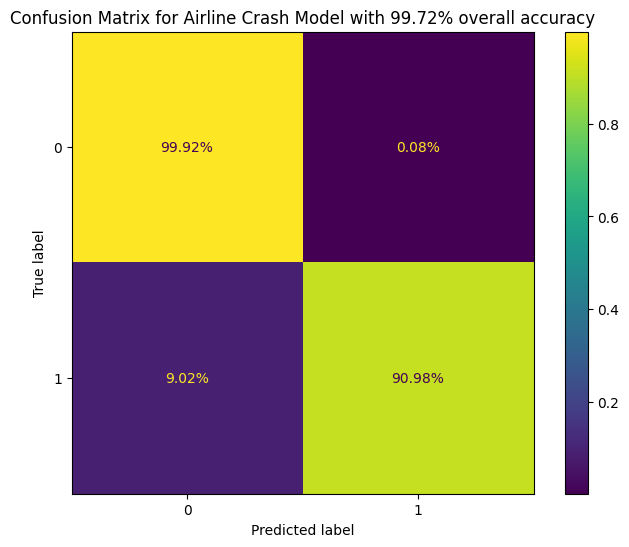

In [ ]:
# plot the optimized model on a confusion matrix
confusion_plot(y_test, y_pred, optimized_hist_boost_model)

## 6. Probability distributions

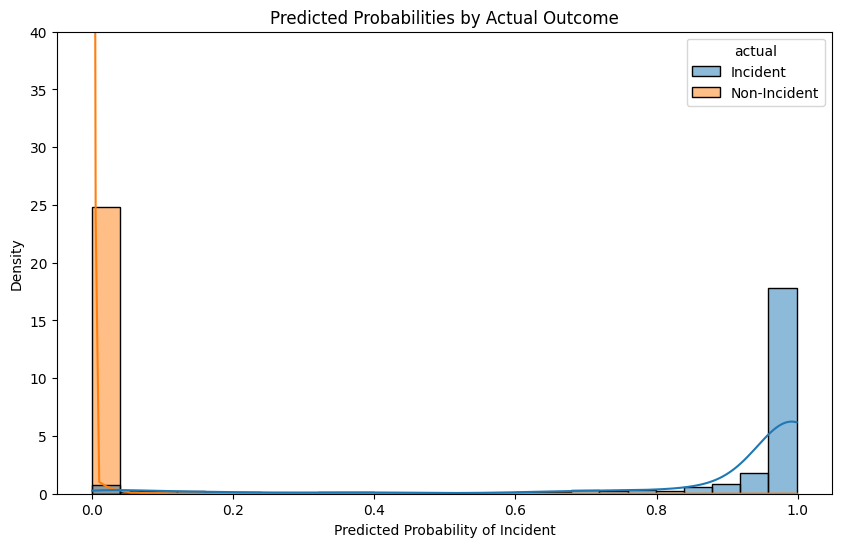

In [ ]:
# plot the distributions of predicted probabilities for 
probabilities_plot(optimized_hist_boost_model, test_df)

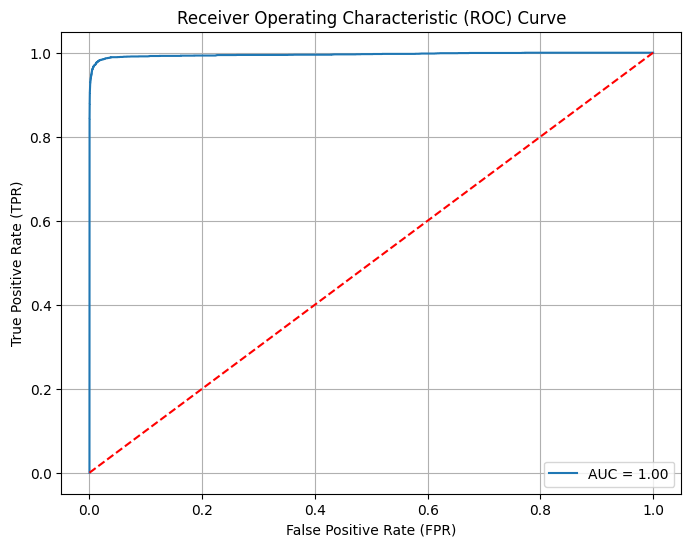

AUC Score: 1.00


In [10]:
def roc_au_plot(model, testing_data):
    y_true = testing_data['incident']
    X_test = testing_data.drop(columns=['incident'])
    prob_incident = model.predict_proba(X_test)[:, 1]
    
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, prob_incident)

    # Calculate the AUC score
    auc_score = roc_auc_score(y_test, prob_incident)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'r--') # Plot the diagonal line for random guessing
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    print(f'AUC Score: {auc_score:.2f}')

roc_au_plot(optimized_hist_boost_model, test_df)

## 7. Save the best model

In [26]:
Path(config.MODEL_DIRECTORY).mkdir(parents=True, exist_ok=True)

with open(config.MODEL, 'wb') as output_file:
    pickle.dump(optimized_hist_boost_model, output_file)
    